In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.11.0
TFP version: 0.19.0


In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [82]:
## Use this to Load Fashion MNIST

# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# x_train = x_train.astype('float32')/255.
# x_test = x_test.astype('float32')/255.


In [62]:
class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

In [63]:
#loaded from above (already scaled.)
loaded_data = np.load('mnist_data.npz')


x_train = loaded_data['array1']
y_train = loaded_data['array2']
x_test = loaded_data['array3']
y_test = loaded_data['array4']

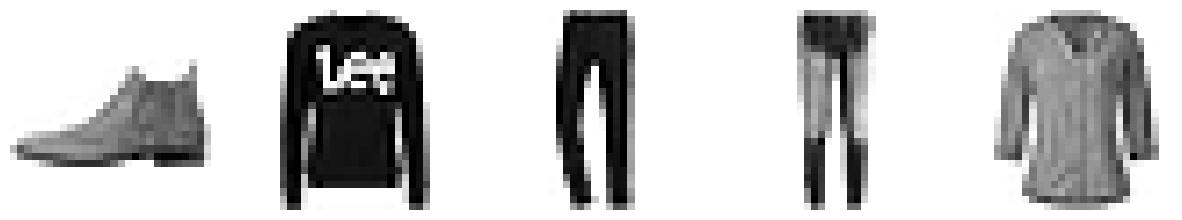

In [64]:
n_examples = 1000
example_images = x_test[0:n_examples]
example_labels = y_test[0:n_examples]

f, axs = plt.subplots(1, 5, figsize=(15, 4))
for j in range(len(axs)):
    axs[j].imshow(example_images[j], cmap='binary')
    axs[j].axis('off')

In [65]:
#define encoding distribution, q(z|x)

latent_size = 2    #modelling choice
event_shape = (28,28)    #size of image

encoder = Sequential([
    Flatten(input_shape = event_shape),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(2*latent_size),
    tfpl.DistributionLambda(
        lambda t : tfd.MultivariateNormalDiag(
        loc = t[..., :latent_size],
        scale_diag = tf.math.exp(t[..., latent_size:])))
])

In [66]:
example_x = x_test[:18]
encoder(example_x)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[18] event_shape=[2] dtype=float32>

Gives out a distribution with event_shape = 2 (no. of latent variables) and batch_shape = 18 (no of images taken)

In [67]:
#decoding dist p(x|z)

decoder = Sequential([
    Dense(32, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(tfpl.IndependentBernoulli.params_size(event_shape)),
    tfpl.IndependentBernoulli(event_shape)
])

In [68]:
decoder(tf.random.normal([16, latent_size]))

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[16] event_shape=[28, 28] dtype=float32>

In [69]:
#prior
prior = tfd.MultivariateNormalDiag(loc = tf.zeros(latent_size))
#Identity covariance

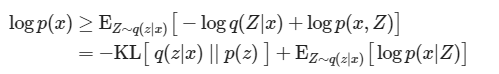

In [83]:
#we take monte carlo estimates of Expectation from q(z|x)
def loss(x, encoding_dist, sampled_decoding_dist, prior):
    return tf.reduce_sum(
    tfd.kl_divergence(encoding_dist, prior) - sampled_decoding_dist.log_prob(x)
    )

In [71]:
@tf.function
def get_loss_and_grads(x):
    with tf.GradientTape() as tape:
        encoding_dist = encoder(x)
        sampled_z = encoding_dist.sample()
        sampled_decoding_dist = decoder(sampled_z)
        current_loss = loss(x, encoding_dist, sampled_decoding_dist, prior)
    grads = tape.gradient(current_loss, encoder.trainable_variables + decoder.trainable_variables)
    return current_loss, grads

In [72]:
batch_size = 64
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

In [73]:
num_epochs = 5
opt = tf.keras.optimizers.Adam()
for i in range(num_epochs):
    for train_batch in x_train:
        current_loss, grads = get_loss_and_grads(train_batch)
        opt.apply_gradients(zip(grads, encoder.trainable_variables
                                       + decoder.trainable_variables))
        
    print('-ELBO after epoch {}: {:.0f}'.format(i+1, current_loss.numpy()))

-ELBO after epoch 1: 8974
-ELBO after epoch 2: 8848
-ELBO after epoch 3: 8801
-ELBO after epoch 4: 8748
-ELBO after epoch 5: 8800


In [78]:
#Constructing encoder-decoder sequence
def vae(inputs):
    approx_posterior = encoder(inputs)
    decoding_dist = decoder(approx_posterior.sample())
    return decoding_dist.mean()

example_reconstruction = vae(example_x).numpy()

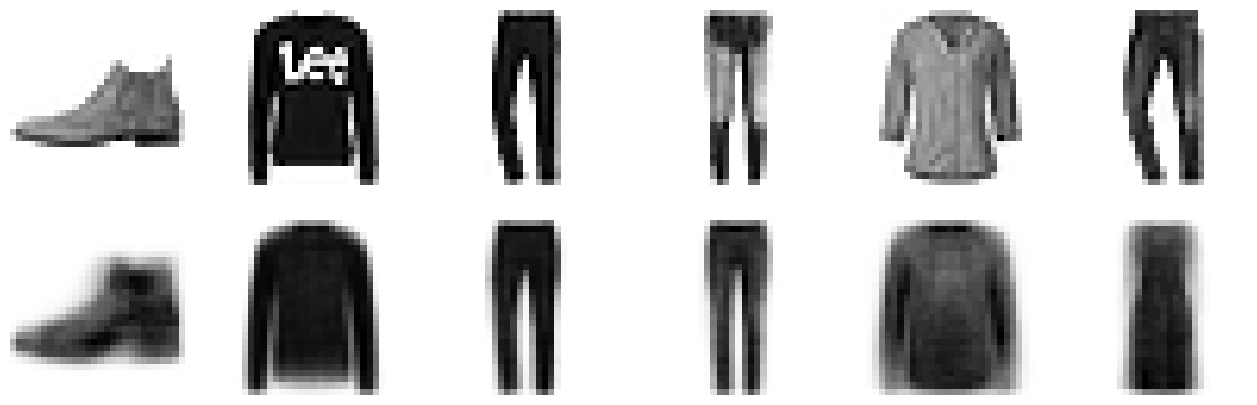

In [79]:
f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_x[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

In [84]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)
z = prior.sample(6)
generated_x = decoder(z).mean() #mean works better than samples 

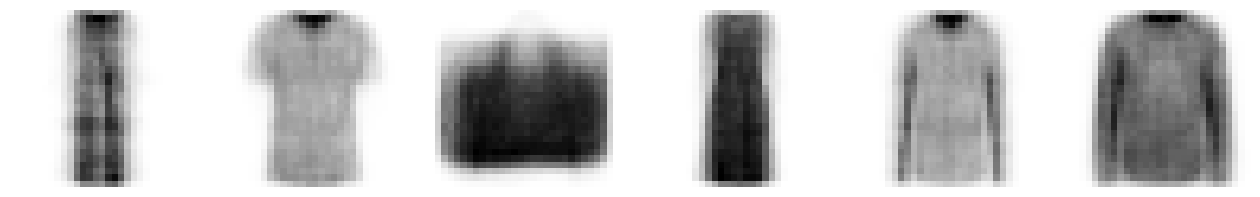

In [81]:
# Display generated_x

f, axs = plt.subplots(1, 6, figsize=(16, 5))
for j in range(6):
    axs[j].imshow(generated_x[j, :, :].numpy().squeeze(), cmap='binary')
    axs[j].axis('off')